In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import Normalizer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
#df = pd.read_csv("articles1.csv")
#df.head()

# from google.colab import drive
# drive.mount('/content/drive')
# folder_path = '/content/drive/My Drive/CTDS Data'
# os.chdir(folder_path)
# !ls

# Import data
df1 = pd.read_csv('articles1.csv')
df2 = pd.read_csv('articles2.csv')
df3 = pd.read_csv('articles3.csv')

df12 = pd.concat([df1,df2])
df   = pd.concat([df12,df3])

# Merge data into one dataframe
#frames = [df1, df2, df3]
#data = pd.concat(frames)
#display(data.head())
# Convert data column into datetime
df['date'] = pd.to_datetime(df['date'],format='mixed')

In [3]:
# df['YM2'] = str(df['year']) + " " + str(df['month'])

df['year-month'] = df["date"].dt.strftime('%Y-%m')
# df['Year-Month'] = pd.to_datetime(df['Year-Month'], format="%Y-%m")


In [4]:
# Let's check null values
# null_mask = df.isnull().any(axis=1)
# null_rows = df.loc[df['date'].isnull() | df['Gender'].isnull() | df['Salary'].isnull()]
null_rows = df.loc[df['date'].isnull()]
# null_rows = df[null_mask]

In [5]:
null_rows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2641 entries, 7140 to 3449
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   2641 non-null   int64         
 1   id           2641 non-null   int64         
 2   title        2641 non-null   object        
 3   publication  2641 non-null   object        
 4   author       1683 non-null   object        
 5   date         0 non-null      datetime64[ns]
 6   year         0 non-null      float64       
 7   month        0 non-null      float64       
 8   url          2639 non-null   object        
 9   content      2641 non-null   object        
 10  year-month   0 non-null      object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 247.6+ KB


In [6]:
null_rows.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,year-month
7140,60459,82749,"\nIranian footage shows US sailor apology, arr...",Fox News,Todd Starnes,NaT,NaN,NaN,NaN,"To use ArchiveBot, drop by #archivebot on EF...",NaN
7159,60478,82769,\nGloves off for top tier in GOP race after de...,Fox News,Peter Gadiel,NaT,NaN,NaN,NaN,"High voltage politics from Chris Stirewalt, D...",NaN
11362,64682,87499,Trump Praises ’Very Smart’ Putin For ’Great Mo...,Talking Points Memo,Esme Cribb,NaT,NaN,NaN,https://web.archive.org/web/20170101011209/htt...,"In a tweet published Friday afternoon, Donal...",NaN
11363,64683,87500,House Dems Vow To Fight Back Against GOP Respo...,Talking Points Memo,Esme Cribb,NaT,NaN,NaN,https://web.archive.org/web/20170101011209/htt...,Senior House Democrats plan to push back again...,NaN
11364,64684,87501,Obama To Meet With Hill Dems Wednesday To Disc...,Talking Points Memo,Tierney Sneed,NaT,NaN,NaN,https://web.archive.org/web/20170101011209/htt...,President Obama will meet with congressional D...,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142570 entries, 0 to 42570
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   142570 non-null  int64         
 1   id           142570 non-null  int64         
 2   title        142568 non-null  object        
 3   publication  142570 non-null  object        
 4   author       126694 non-null  object        
 5   date         139929 non-null  datetime64[ns]
 6   year         139929 non-null  float64       
 7   month        139929 non-null  float64       
 8   url          85559 non-null   object        
 9   content      142570 non-null  object        
 10  year-month   139929 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 13.1+ MB


In [8]:
df.head(10)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,year-month
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,2016-12
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",2017-06
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",2017-01
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",2017-04
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",2017-01
5,5,17288,"Sick With a Cold, Queen Elizabeth Misses New Y...",New York Times,Sewell Chan,2017-01-02,2017.0,1.0,NaN,"LONDON — Queen Elizabeth II, who has been b...",2017-01
6,6,17289,Taiwan’s President Accuses China of Renewed In...,New York Times,Javier C. Hernández,2017-01-02,2017.0,1.0,NaN,BEIJING — President Tsai of Taiwan sharpl...,2017-01
7,7,17290,"After ‘The Biggest Loser,’ Their Bodies Fought...",New York Times,Gina Kolata,2017-02-08,2017.0,2.0,NaN,"Danny Cahill stood, slightly dazed, in a blizz...",2017-02
8,8,17291,"First, a Mixtape. Then a Romance. - The New Yo...",New York Times,Katherine Rosman,2016-12-31,2016.0,12.0,NaN,"Just how is Hillary Kerr, the founder of ...",2016-12
9,9,17292,Calling on Angels While Enduring the Trials of...,New York Times,Andy Newman,2016-12-31,2016.0,12.0,NaN,Angels are everywhere in the Muñiz family’s ap...,2016-12


In [9]:
authors_count = df['author'].value_counts()

In [10]:
authors_count.head(30)

author
Breitbart News          1559
Pam Key                 1282
Associated Press        1231
Charlie Spiering         928
Jerome Hudson            806
John Hayward             747
Daniel Nussbaum          735
AWR Hawkins              720
Ian Hanchett             647
Joel B. Pollak           624
Post Editorial Board     620
Alex Swoyer              604
Camila Domonoske         593
Warner Todd Huston       545
NPR Staff                514
Jeff Poor                505
Merrit Kennedy           484
Trent Baker              457
Breitbart London         447
Katherine Rodriguez      435
Reuters                  434
Charlie Nash             421
Bill Chappell            412
Ben Kew                  373
Frances Martel           366
David French             363
German Lopez             354
David A. Graham          351
Bob Price                340
Esme Cribb               338
Name: count, dtype: int64

In [11]:
year_month_count = df['year-month'].value_counts()
len(year_month_count)

91

In [12]:
# ym_df = pd.DataFrame(year_month_count)
year_month_count.keys()

Index(['2017-03', '2017-04', '2017-01', '2017-02', '2016-12', '2016-11',
       '2016-09', '2016-08', '2016-10', '2017-05', '2016-07', '2016-06',
       '2016-03', '2016-04', '2016-01', '2016-02', '2016-05', '2017-06',
       '2015-06', '2015-03', '2015-04', '2015-01', '2015-05', '2015-07',
       '2015-12', '2015-02', '2017-07', '2015-08', '2013-09', '2014-12',
       '2013-07', '2013-08', '2015-11', '2013-05', '2013-06', '2013-10',
       '2013-01', '2015-10', '2012-12', '2014-11', '2013-04', '2014-07',
       '2013-03', '2014-10', '2014-08', '2015-09', '2013-02', '2014-09',
       '2014-06', '2013-11', '2014-01', '2014-05', '2014-03', '2014-02',
       '2014-04', '2013-12', '2012-05', '2012-09', '2009-04', '2012-02',
       '2011-02', '2010-11', '2012-07', '2012-10', '2012-08', '2012-06',
       '2012-04', '2000-05', '2012-03', '2008-11', '2010-05', '2011-07',
       '2008-07', '2010-07', '2011-11', '2011-10', '2003-09', '2005-08',
       '2004-06', '2011-05', '2010-01', '2010-06', 

In [13]:
ym_df = pd.DataFrame(year_month_count.keys())
ym_df['count'] = year_month_count.values

In [14]:
ym_df.head(63)
# ym_df.info()

,year-month,count
0,2017-03,9581
1,2017-04,9353
2,2017-01,9329
3,2017-02,8622
4,2016-12,8081
...,...,...
58,2009-04,2
59,2012-02,2
60,2011-02,2
61,2010-11,2


In [15]:
ym_df.to_csv('year-data.csv', index=False)

In [16]:
# type(df_authors)

In [17]:
publications_count = df['publication'].value_counts()

In [18]:
# publications_count.head(10)

In [19]:
# How many unique news media are represented in the data?
# publications_count.info()
# = 15 entries

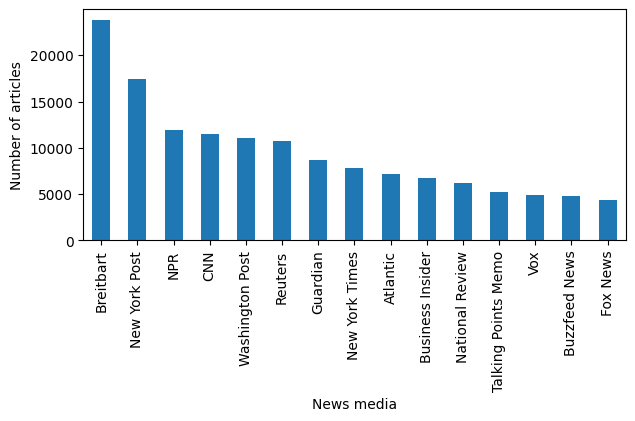

In [22]:
fig, ax = plt.subplots(figsize=(7, 3))
publications_count.plot(ax=ax, kind='bar')
# ax.set_title('Number of articles by news media')
ax.set_ylabel('Number of articles')
ax.set_xlabel('News media')
# fig.tight_layout()
plt.savefig('article-dist.png', bbox_inches='tight')

In [21]:
def process_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)

    tokens = [word for word in text.split()]

    processed_words = [word for word in tokens]

    return ' '.join(processed_words)

df['processed_content'] = df['content'].apply(process_text)

KeyboardInterrupt: 

In [ ]:
df.head(10)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,year-month,processed_content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,2016-12,washington congressional republicans have a ne...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",2017-06,after the bullet shells get counted the blood ...
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",2017-01,when walt disneys bambi opened in critics prai...
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",2017-04,death may be the great equalizer but it isnt n...
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",2017-01,seoul south korea north koreas leader kim said...
5,5,17288,"Sick With a Cold, Queen Elizabeth Misses New Y...",New York Times,Sewell Chan,2017-01-02,2017.0,1.0,NaN,"LONDON — Queen Elizabeth II, who has been b...",2017-01,london queen elizabeth ii who has been battlin...
6,6,17289,Taiwan’s President Accuses China of Renewed In...,New York Times,Javier C. Hernández,2017-01-02,2017.0,1.0,NaN,BEIJING — President Tsai of Taiwan sharpl...,2017-01,beijing president tsai of taiwan sharply criti...
7,7,17290,"After ‘The Biggest Loser,’ Their Bodies Fought...",New York Times,Gina Kolata,2017-02-08,2017.0,2.0,NaN,"Danny Cahill stood, slightly dazed, in a blizz...",2017-02,danny cahill stood slightly dazed in a blizzar...
8,8,17291,"First, a Mixtape. Then a Romance. - The New Yo...",New York Times,Katherine Rosman,2016-12-31,2016.0,12.0,NaN,"Just how is Hillary Kerr, the founder of ...",2016-12,just how is hillary kerr the founder of a digi...
9,9,17292,Calling on Angels While Enduring the Trials of...,New York Times,Andy Newman,2016-12-31,2016.0,12.0,NaN,Angels are everywhere in the Muñiz family’s ap...,2016-12,angels are everywhere in the muiz familys apar...


In [ ]:
word_counts = Counter()
for idx, row in df.iterrows():
    words = row['processed_content'].split()
    word_counts.update(words)


In [ ]:
num_unique_words = 0
num_words_total = 0
# x = 0
for word, count in word_counts.items():
    # print(word)
    # print(str(num_unique_words))
    num_unique_words += 1
    # print(str(num_unique_words))
    num_words_total += count
    # x = x + 1
    # if x >= 20:
        # break

print("Unique words: " + str(num_unique_words))
print("Total words: " + str(num_words_total))
print(len(word_counts.items()))

Unique words: 324677
Total words: 103085868
324677


In [ ]:
# Limit df for analysis
df = df.head(500)
df.shape

(500, 12)

In [ ]:
df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,year-month,processed_content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,2016-12,washington congressional republicans have a ne...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",2017-06,after the bullet shells get counted the blood ...
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",2017-01,when walt disneys bambi opened in critics prai...
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",2017-04,death may be the great equalizer but it isnt n...
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",2017-01,seoul south korea north koreas leader kim said...


In [ ]:
# NLTK downloads
nltk.download('stopwords')
nltk.download('punkt')

# Define NLTK stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

# Tokenization and text preprocessing
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalnum()]
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def preprocess_titles(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalnum()]
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def split_document(document):
    return document.split()

# Preprocess the 'content' column and create a list of the preprocessed text
# df['content'] = df['content'].apply(preprocess_text)
# docs = df['content'].tolist()

df['title'] = df['title'].apply(preprocess_titles)
docs = df['title'].tolist()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arime\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Calculate Term Frequency (TF)
tf = []
for doc in docs:
    words = doc.split()
    word_count = Counter(words)
    tf.append(word_count)

# Calculate Inverse Document Frequency (IDF)
def idf_calc(docs, tf):
    idf = {}
    total_docs = len(docs)

    for doc in tf:
        for word in doc:
            if word not in idf:
                doc_count = sum(1 for d in tf if word in d)
                idf[word] = math.log(total_docs / (1 + doc_count))

    return idf

idf = idf_calc(docs, tf)

# Compute TF-IDF
tfidf = []
for doc in tf:
    tfidf_doc = {word: count * idf[word] for word, count in doc.items()}
    tfidf.append(tfidf_doc)

# Create a DataFrame
df_tfidf = pd.DataFrame(tfidf).fillna(0)

In [ ]:
# TFIDF Dataframe
df_tfidf

,hous,republican,fret,win,health,care,suit,new,york,time,...,superhost,matriarch,beyoncé,solang,quicken,loan,mortgag,island,pakistani,market
0,3.816713,3.729701,5.115996,4.828314,3.912023,4.60517,5.115996,-0.001998,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,5.521461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,0.000000,5.521461,5.521461,5.521461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
497,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.003996,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,5.521461,5.521461,5.521461,0.000000,0.000000,0.000000
498,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.521461,0.000000,0.000000


In [ ]:
# Specify the number of clusters (K)
num_clusters = 10  # You can adjust this based on your needs

# Initialize the K-means model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to the normalized TF-IDF data
kmeans.fit(df_tfidf)

# Get the cluster assignments for each document
cluster_labels = kmeans.labels_

# Add the cluster labels to the original DataFrame (df_tfidf)
df['cluster'] = cluster_labels
print(df)

     Unnamed: 0     id                                              title  \
0             0  17283  hous republican fret win health care suit new ...   
1             1  17284  rift offic resid kill persist south bronx new ...   
2             2  17285  tyrus wong bambi artist thwart racial bias die...   
3             3  17286  among death 2016 heavi toll pop music new york...   
4             4  17287  kim say north korea prepar test missil new yor...   
..          ...    ...                                                ...   
495         495  17846                guid airbnb superhost new york time   
496         496  17847      matriarch behind beyoncé solang new york time   
497         497  17848      quicken loan new mortgag machin new york time   
498         498  17849    long island wind power test water new york time   
499         499  17850  pakistani taliban claim dead market bomb new y...   

        publication                         author       date    year  mont

In [ ]:
cluster_labels

array([3, 4, 4, 4, 4, 4, 1, 4, 4, 4, 2, 2, 2, 4, 4, 8, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 3, 5, 2, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 3, 5, 4, 1, 2,
       5, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 2, 5, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 1, 2, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2,
       4, 4, 2, 3, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2,
       4, 1, 4, 2, 2, 2, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4,
       4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 4, 1, 4, 4, 4, 4, 7, 4, 4, 4, 2, 4,
       4, 5, 4, 4, 4, 2, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 1, 4, 4, 2, 4, 4,
       4, 4, 9, 2, 4, 4, 4, 4, 4, 7, 4, 4, 2, 3, 4, 2, 4, 4, 2, 4, 4, 4,
       4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 2, 2, 5, 5, 4, 4, 4, 4, 4, 4,
       4, 4, 2, 4, 5, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       2, 4, 2, 2, 5, 2, 4, 4, 2, 4, 4, 3, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 1, 4, 4, 4, 4, 4, 4, 4, 5, 2, 4, 2, 2, 4, 2, 2, 5, 4, 3, 2, 7,
       4, 4, 4, 4, 4, 4, 4, 7, 4, 3, 4, 4, 3, 4, 2,

In [ ]:
# intializing the list

# initializing dict to store frequency of each element
elements_count = {}
# iterating over the elements for frequency
for element in cluster_labels:
   # checking whether it is in the dict or not
   if element in elements_count:
      # incerementing the count by 1
      elements_count[element] = elements_count[element] + 1
   else:
      # setting the count to 1
      elements_count[element] = 1
# printing the elements frequencies
for key, value in elements_count.items():
   print(f"{key}: {value}")

3: 15
4: 349
1: 13
2: 80
8: 1
5: 28
7: 10
0: 2
9: 1
6: 1


In [ ]:
def create_first_max_values(df_tfidf):
  maxValues = df_tfidf.max(axis=1) # Max tf-idf value for each row (article)
  maxValueIndex = df_tfidf.idxmax(axis=1) # Column index (= a word) of the max values
  # Set found values zero
  i = 0
  for index in maxValueIndex:
    df_tfidf.loc[i, index] = 0
    i = i + 1
  df_maxValuesIndex = maxValueIndex.to_frame(name="Max Index 0") # Convert to dataframe
  df_maxValuesIndex['Max Values 0'] = maxValues # add the values
  return df_maxValuesIndex, df_tfidf

def create_next_max_values(df_tfidf, df_max):
  # df_max.to_csv('TEST-data-max.csv', index=False)
  maxValues = df_tfidf.max(axis=1) # Max tf-idf value for each row (article)
  maxValueIndex = df_tfidf.idxmax(axis=1) # Column index (= a word) of the max values
  # Set found values zero
  i = 0
  for index in maxValueIndex:
    df_tfidf.loc[i, index] = 0
    i = i + 1
  # print("The shape of df-max is now: " + str(df_max.shape))
  temp = df_max.shape[1]/2
  # print("So the name index we use is: " + str(temp))
  index_number = "Max Index " + str(int(df_max.shape[1]/2))
  values_index_number = "Max Values " + str(int(df_max.shape[1]/2))
  # print("String is now: " + index_number)
  df_maxValuesIndex = maxValueIndex.to_frame(name=index_number) # Convert to dataframe
  df_maxValuesIndex[values_index_number] = maxValues # add the values
  df_max = pd.concat([df_max, df_maxValuesIndex], axis=1)
  return df_max, df_tfidf

# def get_max_values(df_tfidf):

In [ ]:
df_tfidf.to_csv('PRE-data.csv', index=False)

In [ ]:
df_tfidf

,hous,republican,fret,win,health,care,suit,new,york,time,...,superhost,matriarch,beyoncé,solang,quicken,loan,mortgag,island,pakistani,market
0,3.816713,3.729701,5.115996,4.828314,3.912023,4.60517,5.115996,-0.001998,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,5.521461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,0.000000,5.521461,5.521461,5.521461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
497,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.003996,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,5.521461,5.521461,5.521461,0.000000,0.000000,0.000000
498,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.001998,-0.001998,-0.001998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.521461,0.000000,0.000000


In [ ]:
df_max, df_tfidf = create_first_max_values(df_tfidf)

In [ ]:
# df_tfidf.to_csv('POST-data.csv', index=False)

In [ ]:
# df_max.to_csv('POST-data-max.csv', index=False)

In [ ]:
for x in range(10):
    df_max, df_tfidf = create_next_max_values(df_tfidf, df_max)

In [ ]:
df_tfidf.to_csv('POST2-data.csv', index=False)
df_max.to_csv('POST2-data-max.csv', index=False)

In [ ]:
# df_max, df_tfidf = create_next_max_values(df_tfidf, df_max)

In [ ]:
# df_tfidf.to_csv('POST3-data.csv', index=False)
# df_max.to_csv('POST3-data-max.csv', index=False)

In [ ]:
# maxValues = df_tfidf.max(axis=1)
# # print("Max values:")
# # print(maxValues)
# df_maxVals = maxValues.to_frame(name="Max values")
# # print(type(df_maxVals))
# # print()

# maxValueIndex = df_tfidf.idxmax(axis=1)

# # print("Maximum values of rows are at column index position :")
# # print(maxValueIndex)

# #print(type(maxValueIndex))
# #print(type(df_tfidf))

# df_maxValIdx = maxValueIndex.to_frame(name="Index")
# # print(type(df_maxValIdx))

# # print()

# print("Appended dataframe")
# df_maxValIdx['Max Values'] = maxValues
# # print(type(df_maxValIdx))
# # print(df_maxValIdx.shape)

# #print(df_tfidf.loc[maxValueIndex[0]])

In [ ]:
# df_maxValIdx.loc[2,'Max Values'] = 0

In [ ]:
# df_maxValIdx.shape[1]/2

In [ ]:
# i = 0
# for index in maxValueIndex:
#   print(df_tfidf.loc[i, index])
#   i = i + 1

In [ ]:
# i = 0
# for index in maxValueIndex:
#   df_tfidf.loc[i, index] = 0
#   i = i + 1

In [ ]:
# i = 0
# for index in maxValueIndex:
#   print(df_tfidf.loc[i, index])
#   i = i + 1